In [1]:
This is a copy of my privat kaggle kernel: https://www.kaggle.com/joatom/blend-my-models
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from xgboost import plot_tree
from xgboost import plot_importance

from sklearn.metrics import mean_absolute_error as mmae

import gc

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['xgb-model', 'champs-scalar-coupling', 'nn-model-skf', 'lgb-model', 'cat-model', 'nn-model']


In [2]:
in_path='../input/champs-scalar-coupling/'

#https://www.kaggle.com/joatom/xgb-model/output?scriptVersionId=18171045
# v9
xgb_path='../input/xgb-model/'

#https://www.kaggle.com/joatom/nn-model/notebook?scriptVersionId=18171203
# v26
nn_path='../input/nn-model/'
# 4
nnskf_path='../input/nn-model-skf/'

#https://www.kaggle.com/joatom/lgb-model
#v1
lgb_path='../input/lgb-model/'

#https://www.kaggle.com/joatom/cat-model?scriptVersionId=18610821
#v1
cat_path='../input/cat-model/'

## Validation set of other models

In [3]:
xgb_train=pd.read_csv(xgb_path+'train_valid.csv')
lgb_train=pd.read_csv(lgb_path+'train_valid.csv')
cat_train=pd.read_csv(cat_path+'train_valid.csv')
nn_train=pd.read_csv(nn_path+'train_valid.csv')
train = pd.read_csv(in_path+'train.csv')
nnskf_train=pd.read_csv(nnskf_path+'train_valid.csv')

xgb_train.shape, lgb_train.shape, nn_train.shape, train.shape

((4658147, 2), (4658147, 2), (4658147, 2), (4658147, 6))

In [4]:
xgb_test=pd.read_csv(xgb_path+'submission_last.csv')
lgb_test=pd.read_csv(lgb_path+'submission_last.csv')
cat_test=pd.read_csv(cat_path+'submission_last.csv')
nn_test=pd.read_csv(nn_path+'submission_last.csv')
test = pd.read_csv(in_path+'test.csv')
nnskf_test=pd.read_csv(nnskf_path+'submission_last.csv')

xgb_test.shape, lgb_test.shape, nn_test.shape, test.shape

((2505542, 2), (2505542, 2), (2505542, 2), (2505542, 5))

In [5]:
xgb_train.columns=['id', 'scalar_coupling_xgb']
xgb_test.columns=['id', 'scalar_coupling_xgb']
xgb_train.head()

,id,scalar_coupling_xgb
0,58,4.741749
1,63,5.647248
2,67,4.712883
3,68,-1.854676
4,108,2.614519


In [6]:
lgb_train.columns=['id', 'scalar_coupling_lgb']
lgb_test.columns=['id', 'scalar_coupling_lgb']
lgb_train.head()

,id,scalar_coupling_lgb
0,58,4.530261
1,63,5.280183
2,67,4.419310
3,68,1.365240
4,108,2.365283


In [7]:
cat_train.columns=['id', 'scalar_coupling_cat']
cat_test.columns=['id', 'scalar_coupling_cat']
cat_train.head()

,id,scalar_coupling_cat
0,58,3.806267
1,63,4.672234
2,67,3.761439
3,68,1.397756
4,108,2.644532


In [8]:
nn_train.columns=['id', 'scalar_coupling_nn']
nn_test.columns=['id', 'scalar_coupling_nn']
nn_train.head()

,id,scalar_coupling_nn
0,1058752,2.957861
1,1621272,1.655329
2,3109550,1.795223
3,1098802,4.087893
4,1639788,5.226406


In [9]:
nnskf_train.columns=['id', 'scalar_coupling_nnskf']
nnskf_test.columns=['id', 'scalar_coupling_nnskf']
nnskf_train.head()

,id,scalar_coupling_nnskf
0,1058752,2.578018
1,1621272,1.293684
2,3109550,2.040323
3,1098802,3.967863
4,1639788,5.901874


In [10]:
nn_train['id'][2]

3109550

In [11]:
train_mix = pd.merge(xgb_train, lgb_train, on='id')
train_mix = pd.merge(train_mix, cat_train, on='id')
train_mix = pd.merge(train_mix, nn_train, on='id')
train_mix = pd.merge(train_mix, nnskf_train, on='id')

train_mix = pd.merge(train_mix, train, on='id')
train_mix.head()

,id,scalar_coupling_xgb,scalar_coupling_lgb,scalar_coupling_cat,scalar_coupling_nn,scalar_coupling_nnskf,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,58,4.741749,4.530261,3.806267,4.709358,76.043700,dsgdb9nsd_000009,3,2,3JHC,4.55166
1,63,5.647248,5.280183,4.672234,4.515848,76.043700,dsgdb9nsd_000009,4,2,3JHC,4.55410
2,67,4.712883,4.419310,3.761439,4.805206,76.043700,dsgdb9nsd_000009,5,2,3JHC,4.55341
3,68,-1.854676,1.365240,1.397756,5.405020,76.043700,dsgdb9nsd_000009,6,0,3JHC,2.51865
4,108,2.614519,2.365283,2.644532,2.712826,2.522324,dsgdb9nsd_000013,3,2,3JHC,2.51277


In [12]:
test_mix = pd.merge(xgb_test, lgb_test, on='id')
test_mix = pd.merge(test_mix, cat_test, on='id')
test_mix = pd.merge(test_mix, nn_test, on='id')
test_mix = pd.merge(test_mix, nnskf_test, on='id')

test_mix = pd.merge(test_mix, test, on='id')
test_mix.head()

,id,scalar_coupling_xgb,scalar_coupling_lgb,scalar_coupling_cat,scalar_coupling_nn,scalar_coupling_nnskf,molecule_name,atom_index_0,atom_index_1,type
0,4658153,1.830867,2.281171,2.814166,5.113564,-18.481106,dsgdb9nsd_000015,3,2,3JHC
1,4658157,1.707725,2.272314,2.647591,5.100203,-18.576498,dsgdb9nsd_000015,4,2,3JHC
2,4658160,10.360773,11.357344,10.613030,5.177362,6.522535,dsgdb9nsd_000015,5,2,3JHC
3,4658161,1.541325,2.571270,2.580423,5.117853,-18.582100,dsgdb9nsd_000015,6,0,3JHC
4,4658165,1.414689,2.070042,2.380174,5.127991,-18.581700,dsgdb9nsd_000015,7,0,3JHC


In [13]:
train_mix.drop(['atom_index_0','atom_index_1'],axis=1,inplace=True)
test_mix.drop(['atom_index_0','atom_index_1'],axis=1,inplace=True)

# Bin features

In [14]:
def addBins(df_train, df_test, num_of_bins):
    bin_size=num_of_bins
    qbin_size=num_of_bins
    
    for m in ['xgb','lgb','nn','nnskf','cat']:
        # fit bins
        _,bins=pd.cut(np.concatenate((df_train['scalar_coupling_'+m],df_test['scalar_coupling_'+m]),axis=0),bin_size, retbins=True, labels=False)
        _,qbins=pd.qcut(np.concatenate((df_train['scalar_coupling_'+m],df_test['scalar_coupling_'+m]),axis=0),qbin_size, retbins=True, labels=False)

        # transform bins
        for df in [df_train, df_test]:
            df[m+'_bin_'+str(num_of_bins)] = pd.cut(df['scalar_coupling_'+m], bins=bins, labels=False, include_lowest=True)
            df[m+'_qbin_'+str(num_of_bins)] = pd.cut(df['scalar_coupling_'+m], bins=qbins, labels=False, include_lowest=True)
    
    return df_train, df_test

In [15]:
ttr=train_mix.head(10)
tte=test_mix.head(10)

ttr , tte = addBins(ttr, tte, 5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [16]:
tte.head(10)

,id,scalar_coupling_xgb,scalar_coupling_lgb,scalar_coupling_cat,scalar_coupling_nn,scalar_coupling_nnskf,molecule_name,type,xgb_bin_5,xgb_qbin_5,lgb_bin_5,lgb_qbin_5,nn_bin_5,nn_qbin_5,nnskf_bin_5,nnskf_qbin_5,cat_bin_5,cat_qbin_5
0,4658153,1.830867,2.281171,2.814166,5.113564,-18.481106,dsgdb9nsd_000015,3JHC,1,1,0,1,2,3,0,0,0,2
1,4658157,1.707725,2.272314,2.647591,5.100203,-18.576498,dsgdb9nsd_000015,3JHC,1,1,0,0,2,2,0,0,0,2
2,4658160,10.360773,11.357344,10.613030,5.177362,6.522535,dsgdb9nsd_000015,3JHC,4,4,4,4,2,3,1,2,4,4
3,4658161,1.541325,2.571270,2.580423,5.117853,-18.582100,dsgdb9nsd_000015,3JHC,1,0,0,1,2,3,0,0,0,1
4,4658165,1.414689,2.070042,2.380174,5.127991,-18.581700,dsgdb9nsd_000015,3JHC,1,0,0,0,2,3,0,0,0,0
5,4658168,10.027235,10.832564,10.711869,5.110315,6.619591,dsgdb9nsd_000015,3JHC,4,4,4,4,2,2,1,3,4,4
6,4658219,0.879157,0.868206,1.018535,1.360426,1.927830,dsgdb9nsd_000022,3JHC,1,0,0,0,0,0,1,1,0,0
7,4658225,7.976518,8.150678,8.423069,8.859179,8.620998,dsgdb9nsd_000022,3JHC,4,3,3,3,4,4,1,3,3,3
8,4658230,3.549306,3.469437,3.688332,3.191116,3.102669,dsgdb9nsd_000022,3JHC,2,2,1,2,1,1,1,2,1,2
9,4658239,3.713169,3.543850,3.875673,3.124035,2.624700,dsgdb9nsd_000022,3JHC,2,2,1,2,0,1,1,2,1,3


# Features

In [17]:
def addF(df, type):
    for m in ['xgb','lgb','nn','nnskf','cat']:
        df['max_'+m] = df['scalar_coupling_'+m].max()
        df['min_'+m] = df['scalar_coupling_'+m].min()
        
    #if type in ['2JHC','2JHH']:
    #    df['scalar_coupling_no_nn_bound'] = df['scalar_coupling_nnskf']
    #else:
    df['scalar_coupling_no_nn_bound'] = df['scalar_coupling_nn']
 
    
    #df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_no_nn_bound']in(x['max_nn'],x['min_nn'])) else x['scalar_coupling_no_nn_bound']  ,axis=1)
    
    if type in ['3JHC']:
        df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_no_nn_bound']==(x['min_nn']) else x['scalar_coupling_no_nn_bound']  ,axis=1)
       # df['scalar_coupling_nn'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nn']==(x['min_nn']) else x['scalar_coupling_nn']  ,axis=1)
       # df['scalar_coupling_nnskf'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_nnskf']in(x['max_nnskf'],x['min_nnskf'])) else x['scalar_coupling_nnskf']  ,axis=1)
    elif type in ['2JHH']:
        df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_no_nn_bound']in(x['max_nn'],x['min_nn'])) else x['scalar_coupling_no_nn_bound']  ,axis=1)
       # df['scalar_coupling_nn'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_nn']in(x['max_nn'],x['min_nn'])) else x['scalar_coupling_nn']  ,axis=1)
       # df['scalar_coupling_nnskf'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_nnskf']in(x['max_nnskf'],x['min_nnskf'])) else x['scalar_coupling_nnskf']  ,axis=1)
    elif type in ['2JHN']: #opt no cat 
        df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_no_nn_bound']==(x['min_nn'])) else x['scalar_coupling_no_nn_bound']  ,axis=1)
       # df['scalar_coupling_nn'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nn']==(x['min_nn']) else x['scalar_coupling_nn']  ,axis=1)
       # df['scalar_coupling_nnskf'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nnskf']==(x['min_nnskf']) else x['scalar_coupling_nnskf']  ,axis=1)
    elif type in ['2JHC']: #opt 
        df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_no_nn_bound']==(x['min_nn'])) else x['scalar_coupling_no_nn_bound']  ,axis=1)
       # df['scalar_coupling_nn'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nn']==(x['min_nn']) else x['scalar_coupling_nn']  ,axis=1)
       # df['scalar_coupling_nnskf'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nnskf']==(x['min_nnskf']) else x['scalar_coupling_nnskf']  ,axis=1)
    elif type in ['3JHH']:# opt
        df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_no_nn_bound']==(x['min_nn'])) else x['scalar_coupling_no_nn_bound']  ,axis=1)
       # df['scalar_coupling_nn'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nn']==(x['min_nn']) else x['scalar_coupling_nn']  ,axis=1)
       # df['scalar_coupling_nnskf'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if x['scalar_coupling_nnskf']==(x['min_nnskf']) else x['scalar_coupling_nnskf']  ,axis=1)
    elif type in ['1JHC']:# opt max
        df['scalar_coupling_no_nn_bound'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_no_nn_bound']in(x['max_nn'],x['min_nn'])) else x['scalar_coupling_no_nn_bound']  ,axis=1)
       # df['scalar_coupling_nn'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_nn']in(x['max_nn'],x['min_nn'])) else x['scalar_coupling_nn']  ,axis=1)
       # df['scalar_coupling_nnskf'] = df.apply(lambda x: (x['scalar_coupling_xgb']+x['scalar_coupling_lgb']+x['scalar_coupling_cat'])/3 if (x['scalar_coupling_nnskf']in(x['max_nnskf'],x['min_nnskf'])) else x['scalar_coupling_nnskf']  ,axis=1)
    
    return df

In [18]:
ttr=train_mix.head(20)

ttr = addF(ttr, '3JHC')
ttr.head(20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,id,scalar_coupling_xgb,scalar_coupling_lgb,scalar_coupling_cat,scalar_coupling_nn,scalar_coupling_nnskf,molecule_name,type,scalar_coupling_constant,max_xgb,min_xgb,max_lgb,min_lgb,max_nn,min_nn,max_nnskf,min_nnskf,max_cat,min_cat,scalar_coupling_no_nn_bound
0,58,4.741749,4.530261,3.806267,4.709358,76.043700,dsgdb9nsd_000009,3JHC,4.551660,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,4.709358
1,63,5.647248,5.280183,4.672234,4.515848,76.043700,dsgdb9nsd_000009,3JHC,4.554100,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,4.515848
2,67,4.712883,4.419310,3.761439,4.805206,76.043700,dsgdb9nsd_000009,3JHC,4.553410,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,4.805206
3,68,-1.854676,1.365240,1.397756,5.405020,76.043700,dsgdb9nsd_000009,3JHC,2.518650,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,5.405020
4,108,2.614519,2.365283,2.644532,2.712826,2.522324,dsgdb9nsd_000013,3JHC,2.512770,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,2.712826
5,115,2.749493,2.593622,2.409641,2.331062,2.281923,dsgdb9nsd_000013,3JHC,2.518020,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,2.331062
6,121,9.611028,10.456432,10.278831,10.411016,9.832674,dsgdb9nsd_000013,3JHC,10.439200,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,10.411016
7,137,2.426339,2.692418,2.457103,2.509684,2.434528,dsgdb9nsd_000013,3JHC,2.517980,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,2.509684
8,142,10.007581,10.491503,10.253249,10.367722,9.743996,dsgdb9nsd_000013,3JHC,10.439200,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,10.367722
9,146,2.795274,2.384752,2.625624,2.610594,2.377308,dsgdb9nsd_000013,3JHC,2.512820,10.007581,-1.854676,10.491503,-0.894875,10.411016,-0.210415,76.0437,-0.066673,10.278831,-0.427773,2.610594


In [19]:
#ttr.apply(lambda x: x['scalar_coupling_xgb'] if (x['scalar_coupling_nn']in(x['max_nn'],x['min_nn'])) else x['scalar_coupling_nn']  ,axis=1)

# PLot

In [20]:
#train_mix.groupby('type').plot.scatter(x='scalar_coupling_xgb', y='scalar_coupling_constant')

In [21]:
#train_mix.groupby('type').plot.scatter(x='scalar_coupling_nn', y='scalar_coupling_constant')

In [22]:
#train_mix.groupby('type').plot.scatter(x='scalar_coupling_xgb', y='scalar_coupling_nn')

In [23]:
#train_mix.groupby('type').plot.scatter(x='scalar_coupling_xgb', y='scalar_coupling_nn')

#sns.catplot(x='scalar_coupling_xgb', y='scalar_coupling_nn', col="type",data=train_mix, kind="swarm",height=4, aspect=.7);

In [24]:
#y =  train_mix['scalar_coupling_constant']
#train_mix.drop(['molecule_name','atom_index_0','atom_index_1','scalar_coupling_constant'],axis=1, inplace=True)

In [25]:
train_mix.head()

,id,scalar_coupling_xgb,scalar_coupling_lgb,scalar_coupling_cat,scalar_coupling_nn,scalar_coupling_nnskf,molecule_name,type,scalar_coupling_constant
0,58,4.741749,4.530261,3.806267,4.709358,76.043700,dsgdb9nsd_000009,3JHC,4.55166
1,63,5.647248,5.280183,4.672234,4.515848,76.043700,dsgdb9nsd_000009,3JHC,4.55410
2,67,4.712883,4.419310,3.761439,4.805206,76.043700,dsgdb9nsd_000009,3JHC,4.55341
3,68,-1.854676,1.365240,1.397756,5.405020,76.043700,dsgdb9nsd_000009,3JHC,2.51865
4,108,2.614519,2.365283,2.644532,2.712826,2.522324,dsgdb9nsd_000013,3JHC,2.51277


In [26]:
#train_mix[train_mix['type']=='3JHC'].hist('scalar_coupling_constant')

In [27]:
#output = pd.DataFrame({'id': np.concatenate(fin_preds_idx),
#                       'scalar_coupling_constant': np.concatenate(fin_preds)})
#output.to_csv('submission_last.csv', index=False)

#print('Done!')

# Model


############### 3JHC ###################

fold 1 of 5
[18:13:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.6623
Will train until validation_0-mae hasn't improved in 40 rounds.
[400]	validation_0-mae:0.154138
[800]	validation_0-mae:0.152361
[1200]	validation_0-mae:0.151876
[1600]	validation_0-mae:0.151687
Stopping. Best iteration:
[1604]	validation_0-mae:0.151678

Best iteration: 1604 Best ntree_limit: 1605 Best score: 0.151678
## lr: 0.2 n_est: 20000
fold 2 of 5
[18:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.65914
Will train until validation_0-mae hasn't improved in 40 rounds.
[400]	validation_0-mae:0.154333
[800]	validation_0-mae:0.152536
[1200]	validation_0-mae:0.15199
[1600]	validation_0-mae:0.151804
Stopping. Best iteration:
[1949]	validation_0-mae:0.15173

Best iteration: 1949 Best n

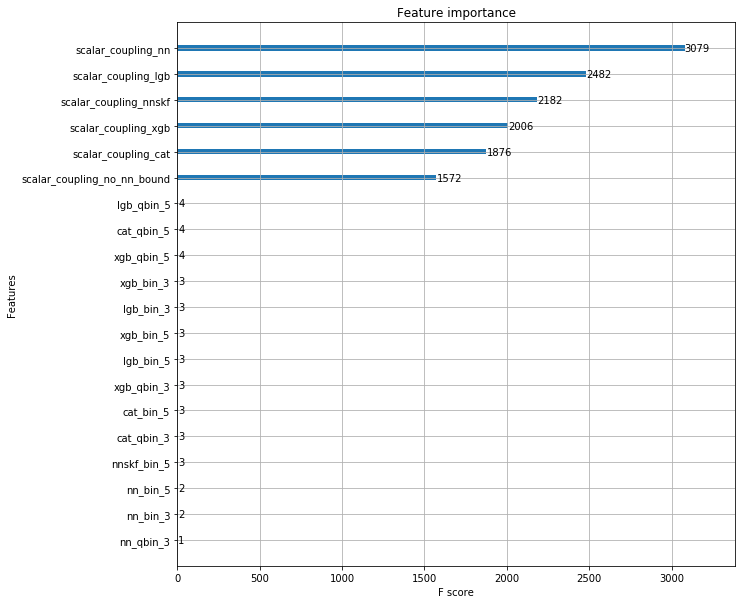

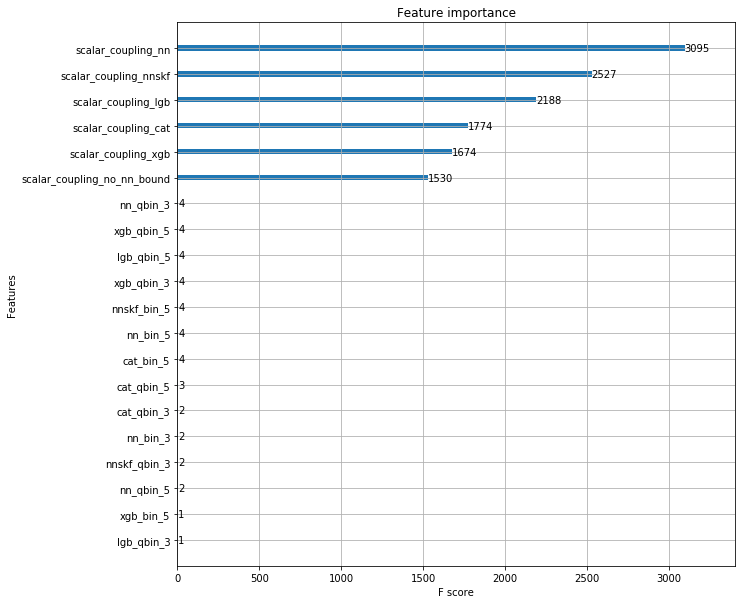

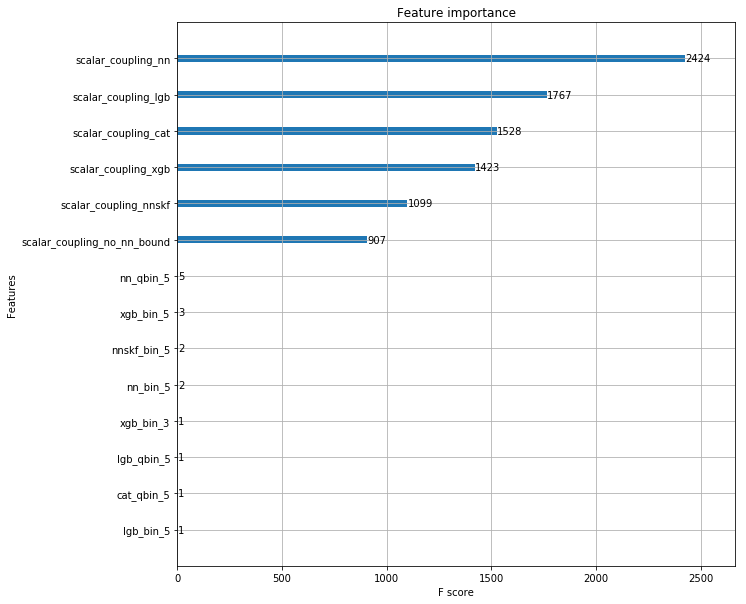

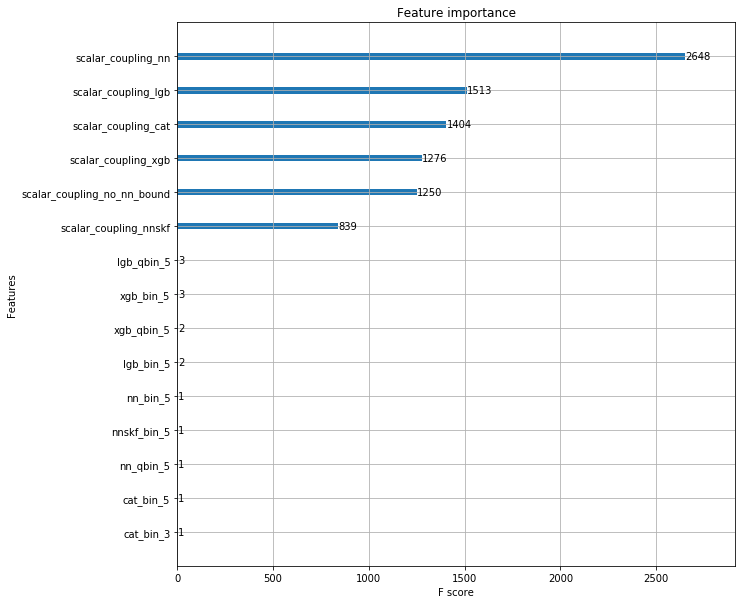

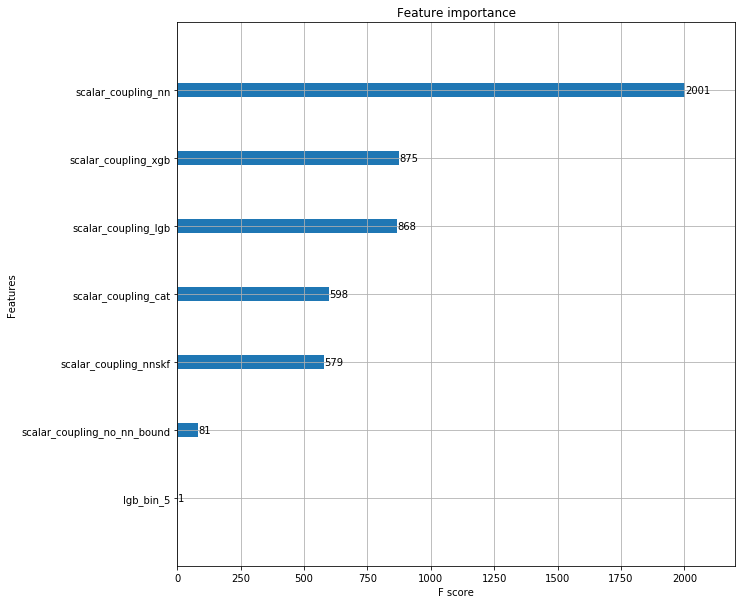

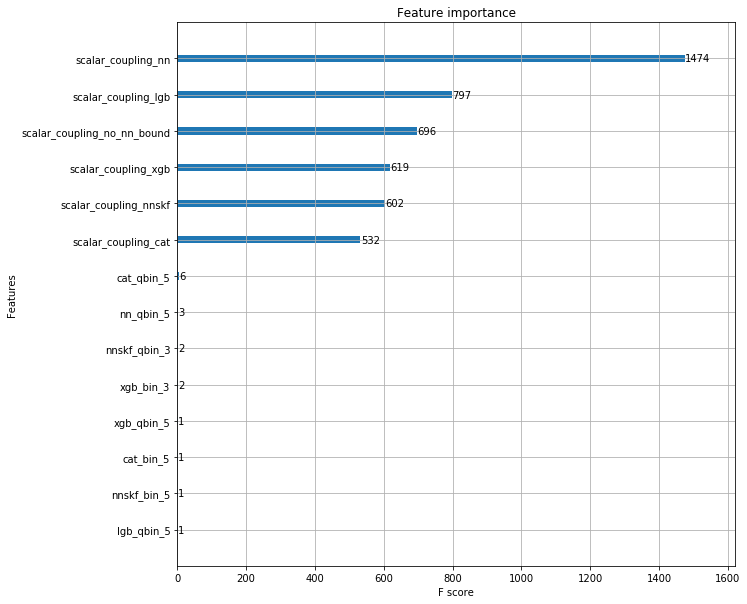

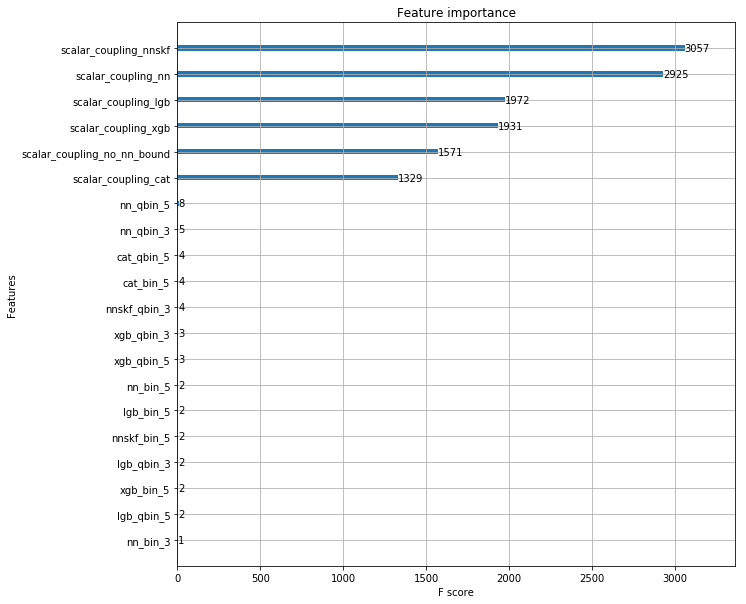

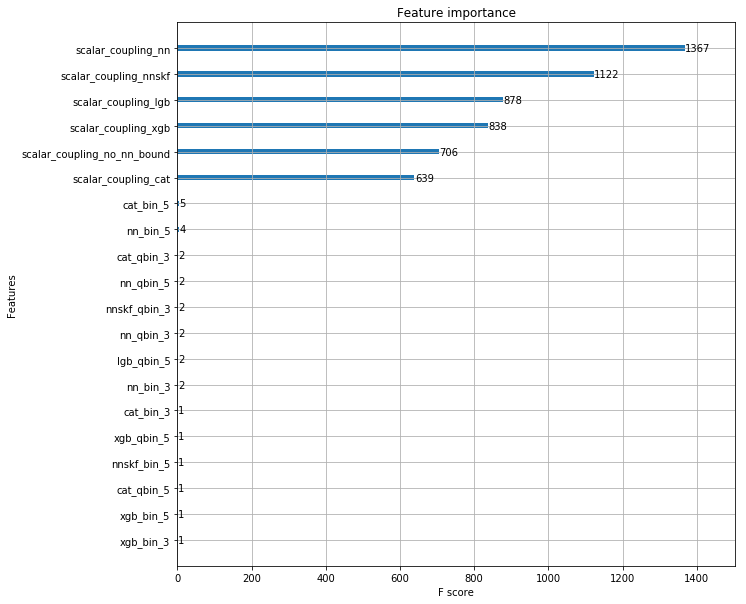

In [28]:

types_to_run = ['3JHC', '2JHC', '1JHC', '2JHH', '1JHN', '2JHN', '3JHH', '3JHN']  #['3JHC']:#['3JHC']:#['1JHN']:#

np.random.seed(2019)
raa_all=[]
fin_preds=[]
fin_preds_idx=[]
nn_preds_valid_a=[]
nn_preds_valid_b=[]
y_valid_nn_a=[]
fin_preds2=[]

lr= 0.2
n_est=20000
dep_var='scalar_coupling_constant'
    
for wctn in types_to_run:
    print('')
    print('###############',wctn,'###################')
    print('')
    bin_size=5
    bin_size2=3
    
    id_train_wctn=train_mix[train_mix['type']==wctn]['id']
    y_train_wctn=train_mix[train_mix['type']==wctn][dep_var]
    X_train_wctn=train_mix[train_mix['type']==wctn].drop(['id','type','molecule_name',dep_var],axis=1)#.reset_index()
    #features=['scalar_coupling_xgb','scalar_coupling_nn','xgb_bin','xgb_qbin','nn_bin','nn_qbin']
    #X_train_wctn=X_train_wctn[features]
    #print(X_train_wctn.info(200))
    id_test_wctn=test_mix[test_mix['type']==wctn]['id']
    X_test_wctn=test_mix[test_mix['type']==wctn].drop(['id','type','molecule_name'],axis=1)
    #X_test_wctn=X_test_wctn[features]    
    
    ## add Features
    X_train_wctn , X_test_wctn = addBins(X_train_wctn, X_test_wctn, bin_size)
    X_train_wctn , X_test_wctn = addBins(X_train_wctn, X_test_wctn, bin_size2)
    X_train_wctn = addF(X_train_wctn, wctn)
    X_test_wctn = addF(X_test_wctn, wctn)
    feature_names=['scalar_coupling_xgb', 
                   'scalar_coupling_lgb', 
                   'scalar_coupling_cat', 
                    'scalar_coupling_nn',
                    'scalar_coupling_nnskf',
                   'xgb_bin_5', 'xgb_qbin_5', 
                   'lgb_bin_5', 'lgb_qbin_5',
                   'cat_bin_5', 'cat_qbin_5',
                    'nn_bin_5',
                    'nnskf_bin_5',
                   'nn_qbin_5', 
                    'xgb_bin_3', 'xgb_qbin_3', 
                    'lgb_bin_3', 'lgb_qbin_3',
                    'cat_bin_3', 'cat_qbin_3',
                    'nnskf_qbin_3',
                   'nn_bin_3', 'nn_qbin_3', 
                    'max_xgb', 'min_xgb', 
                    'max_lgb', 'min_lgb',
                   'max_cat', 'min_cat',
                   'max_nn', 'min_nn',
                    'max_nnskf', 'min_nnskf',
                    'scalar_coupling_no_nn_bound'
                  ]
    
    X_train_wctn = X_train_wctn[feature_names]
    X_test_wctn = X_test_wctn[feature_names]
    
    ## Fold
    n_splits=5

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2019)
    skf =StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019)
    # transfer y to bins and apply stratifiedKFold
    y_bin_4_skf=pd.cut(y_train_wctn,5,labels=False)
    
    yoof = np.zeros(len(X_train_wctn))
    yhat = np.zeros(len(X_test_wctn))

    fold = 0
    for in_index, oof_index in skf.split(X_train_wctn, y_bin_4_skf): # kf.split(X_train_wctn, y_train_wctn):
        fold += 1
        print(f'fold {fold} of {n_splits}')
        X_in, X_oof = X_train_wctn.values[in_index], X_train_wctn.values[oof_index]
        y_in, y_oof = y_train_wctn.values[in_index], y_train_wctn.values[oof_index]
        
        model = XGBRegressor(n_estimators=n_est, learning_rate=lr, random_state=2019, tree_method = 'gpu_exact',max_deth=10)#0.1
        model.fit(X_in, y_in, early_stopping_rounds=40, eval_set=[(X_oof, y_oof)], verbose=400, eval_metric = 'mae')
        
        print('Best iteration: '+ str(model.best_iteration), 'Best ntree_limit: '+ str(model.best_ntree_limit), 'Best score:', str(model.best_score)) #model.best_score,
        
        yoof[oof_index] = model.predict(X_oof)
        yhat += model.predict(X_test_wctn.values)
        
        
        #model=lgb.LGBMRegressor(max_depth= 9, learning_rate= lr, num_leaves= 250,  n_estimators= n_est, n_jobs= -1,reg_alpha=0.8)
        #model = model.fit(X_in, y_in, 
          #          eval_set=[(X_oof, y_oof)], eval_metric='mae',
          #          verbose=400, early_stopping_rounds=20)
        #yoof[oof_index] = model.predict(X_oof,num_iteration=model.best_iteration_)
        #yhat += model.predict(X_test_wctn.values,num_iteration=model.best_iteration_)
        
        print('## lr:',lr,'n_est:',n_est)
        
        gc.collect()

    yhat /= n_splits
    
    fin_preds.append(np.array(yhat))
    fin_preds_idx.append(np.array(id_test_wctn))
    fin_preds2.append(np.array(X_test_wctn.scalar_coupling_no_nn_bound))
    
    # for analysis
    nn_preds_valid_a.append(yoof)
    y_valid_nn_a.append(y_train_wctn)
    nn_preds_valid_b.append(np.array(X_train_wctn.scalar_coupling_no_nn_bound))

    raa=mmae(yoof, y_train_wctn)
    print(wctn,'mae',raa,'mae_out2',mmae(np.array(X_train_wctn.scalar_coupling_no_nn_bound), y_train_wctn))
    raa_all.append(raa)
    
    #fig, ax = plt.subplots(figsize=(30, 30))
    #plot_tree(model,ax=ax)
    #plt.show()
    
    model.get_booster().feature_names=feature_names
    model.feature_types = None
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    plot_importance(model, max_num_features = 20, ax=ax)
    

#1JHN mae 0.1664701839579594 mae_out2 0.23029429575905724 wo skf
#1JHN mae 0.16748937563056385 mae_out2 0.23029429575905724
#1JHN mae 0.16748937563056385 mae_out2 0.23029429575905724 man adj nn + skf
#1JHC mae 0.4073467951444143 mae_out2 0.5314197327599556 wo skf
#1JHC mae 0.40649537720695655 mae_out2 0.5314197327599556
#1JHC mae 0.40659507157148633 mae_out2 0.5314197327599556 man adj nn + skf

In [29]:
#model.booster_.feature_names=feature_names
#model.feature_types = None
#fig, ax = plt.subplots(1,1,figsize=(10,10))
#lgb.plot_importance(model, max_num_features = 20, ax=ax)

In [30]:
types_to_run, np.mean(raa_all), raa_all

(['3JHC', '2JHC', '1JHC', '2JHH', '1JHN', '2JHN', '3JHH', '3JHN'],
 0.147352874391613,
 [0.15162602564807462,
  0.15182260259356303,
  0.4522268408982128,
  0.07021027558561284,
  0.16241610712467014,
  0.06417148754313286,
  0.0822961236552938,
  0.04405353208434378])

((array([3.0000e+01, 7.6630e+03, 9.8476e+04, 3.4314e+04, 1.6421e+04,
         6.4020e+03, 2.2080e+03, 6.9100e+02, 1.9200e+02, 1.8000e+01]),
  array([-3.07589579, -1.75089211, -0.42588844,  0.89911523,  2.2241189 ,
          3.54912257,  4.87412624,  6.19912992,  7.52413359,  8.84913726,
         10.17414093]),
  <a list of 10 Patch objects>),
 (array([1.6510e+03, 3.7568e+04, 3.2040e+04, 9.7530e+03, 6.5470e+03,
         1.6880e+03, 9.3100e+02, 3.3500e+02, 9.1000e+01, 1.2000e+01]),
  array([-1.86950521, -0.69104779,  0.48740963,  1.66586705,  2.84432447,
          4.0227819 ,  5.20123932,  6.37969674,  7.55815416,  8.73661159,
          9.91506901]),
  <a list of 10 Patch objects>))

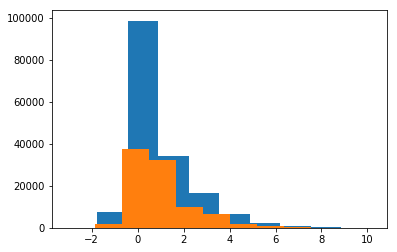

In [31]:
plt.hist(yoof),plt.hist(yhat)

## one-hot-encoding

In [32]:
#train_mix = pd.get_dummies(train_mix)

In [33]:
#train_mix

## scaling

In [34]:
#sc=MinMaxScaler()
#train_mix=sc.fit_transform(train_mix)

## create bins

In [35]:
#pd.cut(train_mix,5)

## Predictions of other models

In [36]:
#xgb_data=pd.read_csv(xgb_path+'submission_last.csv').sort_values(by=['id']).reset_index(drop=True)
#nn_data=pd.read_csv(nn_path+'submission_last.csv').sort_values(by=['id']).reset_index(drop=True)

#submission = pd.read_csv(in_path+'sample_submission.csv').sort_values(by=['id'])

#xgb_data.shape,nn_data.shape,submission.shape

In [37]:
#submission['scalar_coupling_constant'] = (0.4*xgb_data['scalar_coupling_constant'] + 0.6*nn_data['scalar_coupling_constant'])
#submission.to_csv('submission_last.csv', index=False),

#submission.head()

In [38]:
output = pd.DataFrame({'id': np.concatenate(fin_preds_idx),
                       'scalar_coupling_constant': np.concatenate(fin_preds)})
output.to_csv('submission_last.csv', index=False)

print('Done!')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Done!


In [39]:
output2 = pd.DataFrame({'id': np.concatenate(fin_preds_idx),
                       'scalar_coupling_constant': np.concatenate(fin_preds2)})
output2.to_csv('submission_last_man.csv', index=False)

print('Done!')

Done!


In [40]:
output.head()

,id,scalar_coupling_constant
0,4658153,2.893489
1,4658157,2.519480
2,4658160,8.497438
3,4658161,3.051399
4,4658165,3.032240


# oof Preds

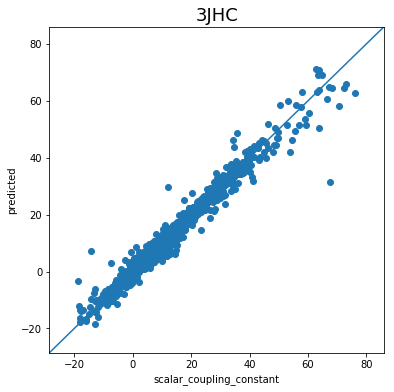

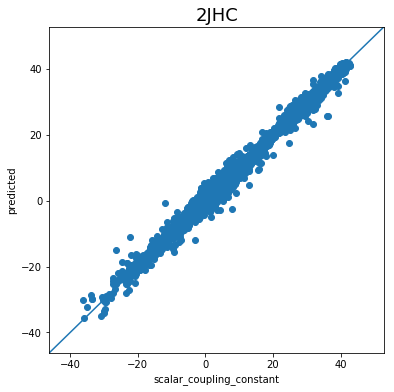

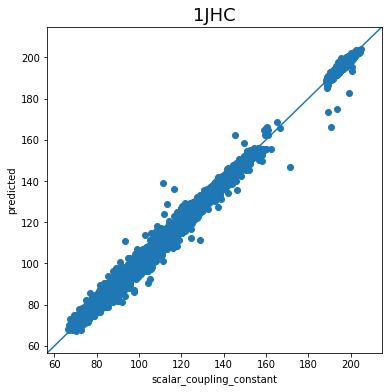

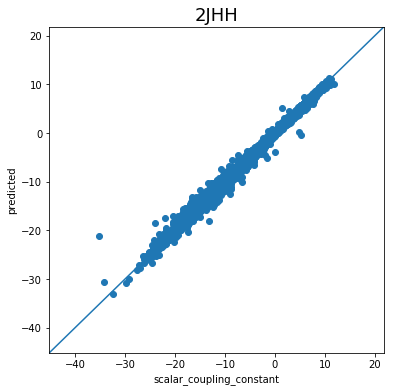

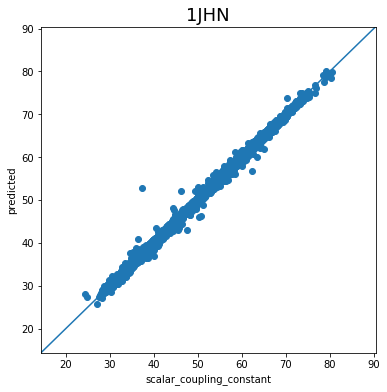

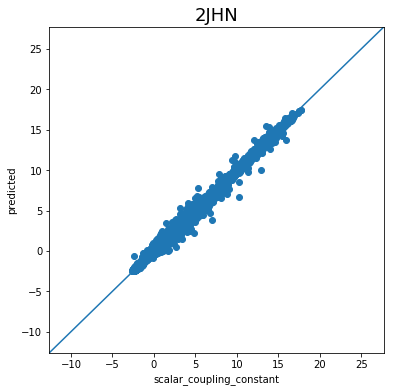

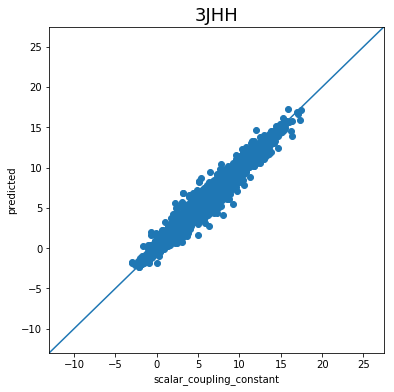

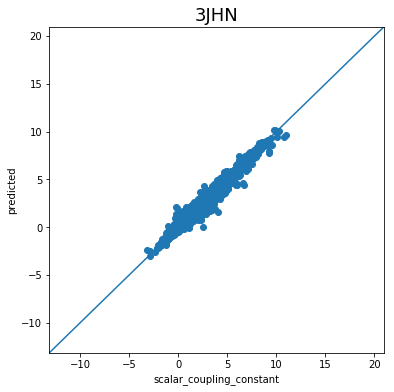

In [41]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_valid_nn_a[i], y=nn_preds_valid_a[i])
    
    llim =min(np.min(nn_preds_valid_a[i]),np.min(y_valid_nn_a[i]))-10
    ulim=max(np.max(nn_preds_valid_a[i]),np.max(y_valid_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

# oof Pred 2

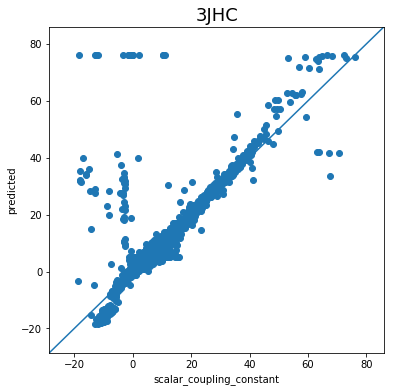

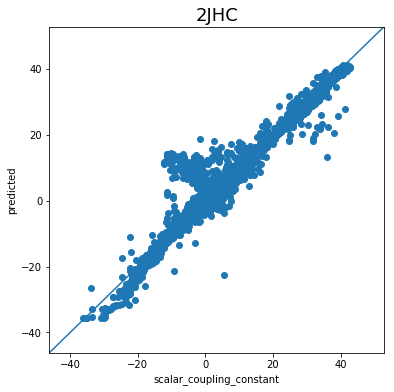

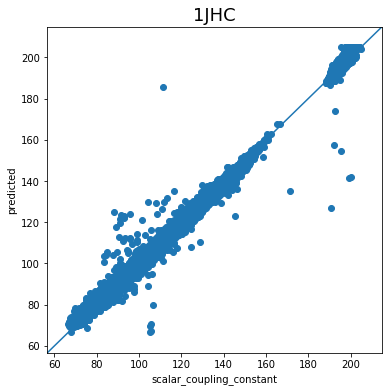

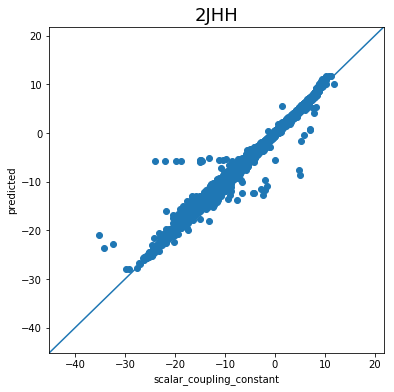

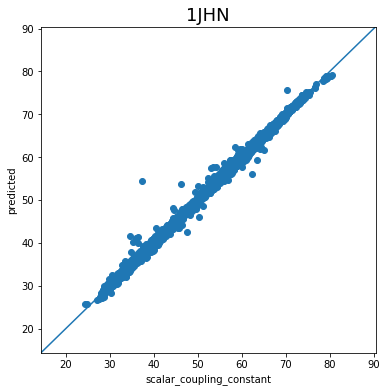

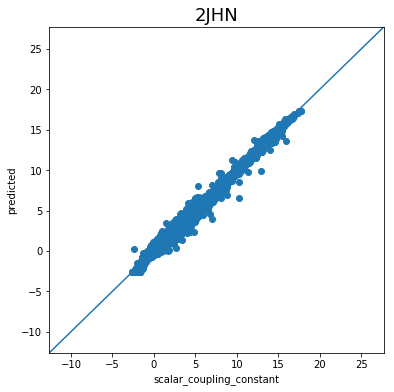

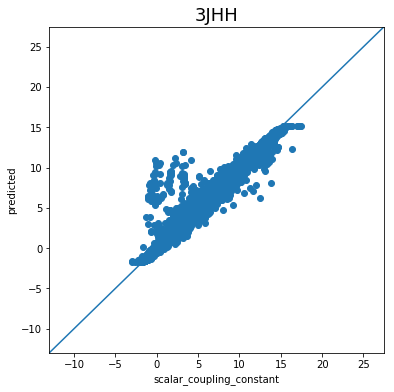

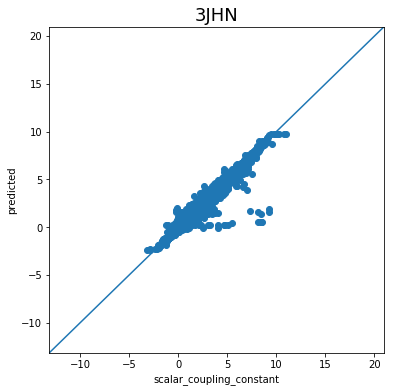

In [42]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_valid_nn_a[i], y=nn_preds_valid_b[i])
    
    llim =min(np.min(nn_preds_valid_a[i]),np.min(y_valid_nn_a[i]))-10
    ulim=max(np.max(nn_preds_valid_a[i]),np.max(y_valid_nn_a[i]))+10
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.xlim((llim, ulim))
    plt.ylim((llim, ulim))
    plt.plot([llim, ulim], [llim, ulim])
    plt.title(t, fontsize=18)
    plt.show()

# Predictions

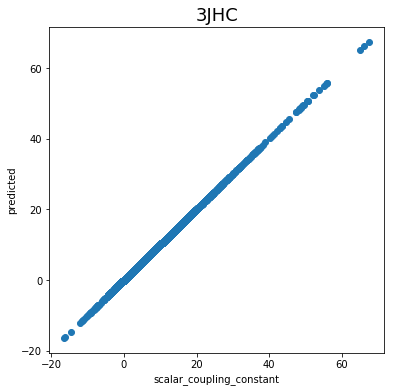

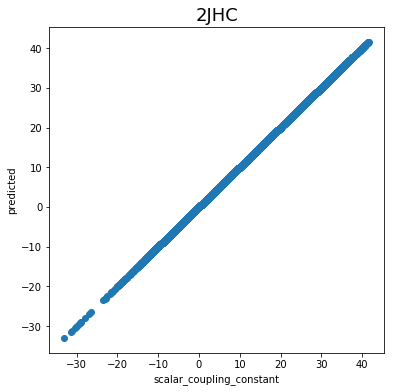

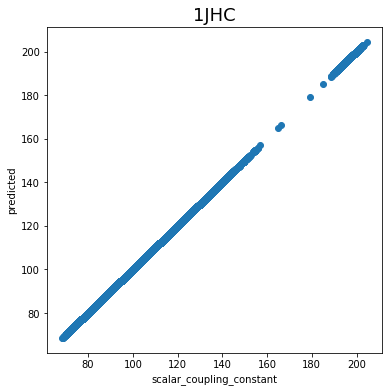

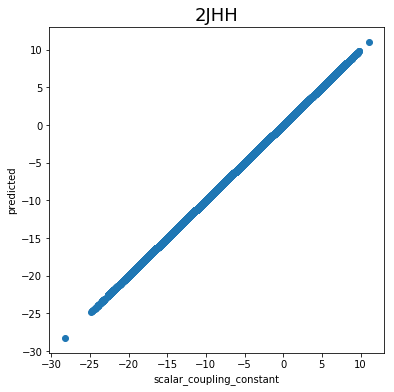

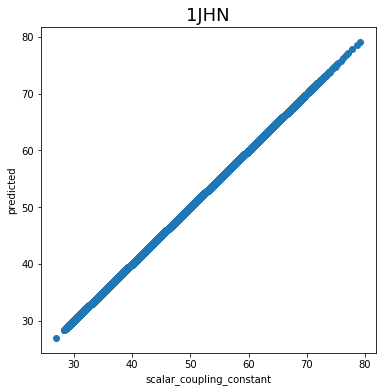

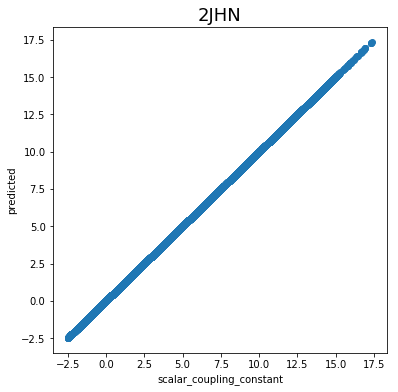

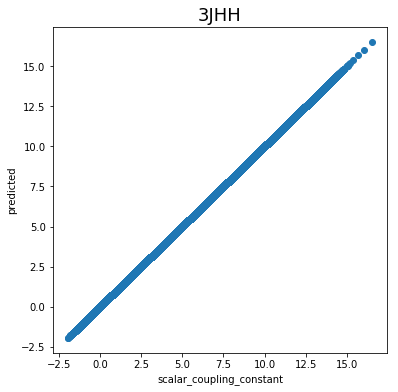

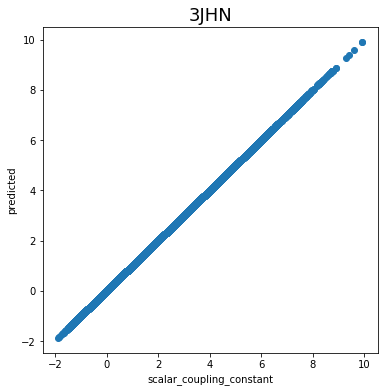

In [43]:
for i,t in enumerate(types_to_run):
    plt.figure(figsize=(6,6))
    
    plt.scatter(x=fin_preds[i], y=fin_preds[i])
    
    plt.xlabel('scalar_coupling_constant')
    plt.ylabel('predicted')
    plt.title(t, fontsize=18)
    plt.show()